In [1]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import lightgbm as lgb
from lightgbm import LGBMClassifier
from bayes_opt import BayesianOptimization
#bayesian-optimization
import matplotlib.pyplot as plt
from sklearn import cross_validation

/usr/local/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# Function for Measure Performance
from  sklearn  import  metrics
def measure_performance(X,y,clf, show_accuracy=True, show_classification_report=True, show_confusion_matrix=True, show_roc_auc = True):
    y_pred = clf.predict(X)
    y_predprob = clf.predict_proba(X)[:,1]
    if show_accuracy:
        print ("Accuracy:{0:.3f}".format(metrics.accuracy_score(y,y_pred))),"\n"

    if show_classification_report:
        print("Classification report")
        print(metrics.classification_report(y,y_pred)),"\n"
        
    if show_confusion_matrix:
        print("Confusion matrix")
        print(metrics.confusion_matrix(y,y_pred)),"\n"  
        
    if show_roc_auc:
        print("ROC AUC Score")
        print(metrics.roc_auc_score(y,y_predprob)),"\n"

In [3]:
#Data Preparation for LightGBM
import os
application_train = pd.read_csv('/Users/francislin/Desktop/Machine_Learning_Workshop/Home Credit Default Risk/application_train.csv')

# use LabelEncoder to convert categorical features to int type before construct Dataset
from sklearn.preprocessing import LabelEncoder
def label_encoder(input_df, encoder_dict=None):
    """ Process a dataframe into a form useable by LightGBM """
    # Label encode categoricals
    categorical_feats = input_df.columns[input_df.dtypes == 'object']
    for feat in categorical_feats:
        encoder = LabelEncoder()
        input_df[feat] = encoder.fit_transform(input_df[feat].fillna('NULL'))
    return input_df, categorical_feats.tolist(), encoder_dict
application_train, categorical_feats, encoder_dict = label_encoder(application_train)
X = application_train.drop('TARGET', axis=1)
y = application_train.TARGET

# Prepare dataset 
seed = 7
test_size = 0.3
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=test_size, random_state=seed)

In [4]:
#bayesian-optimization
def lgb_eval(num_leaves, feature_fraction, bagging_fraction, max_depth, lambda_l1, lambda_l2, min_split_gain, min_child_weight):
    params = {'application':'binary','num_iterations':4000, 'learning_rate':0.05, 'early_stopping_round':100, 'metric':'auc'}
    params["num_leaves"] = int(round(num_leaves))
    params['feature_fraction'] = max(min(feature_fraction, 1), 0)
    params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)
    params['max_depth'] = round(max_depth)
    params['lambda_l1'] = max(lambda_l1, 0)
    params['lambda_l2'] = max(lambda_l2, 0)
    params['min_split_gain'] = min_split_gain
    params['min_child_weight'] = min_child_weight
    cv_result = lgb.cv(params, train_data, nfold=n_folds, seed=random_seed, stratified=True, verbose_eval =200, metrics=['auc'])
    return max(cv_result['auc-mean'])

In [5]:
#Step 2: Set the range for each parameter (make the range as narrow as possible)
lgbBO = BayesianOptimization(lgb_eval, {'num_leaves': (24, 45),
                                        'feature_fraction': (0.1, 0.9),
                                        'bagging_fraction': (0.8, 1),
                                        'max_depth': (5, 8.99),
                                        'lambda_l1': (0, 5),
                                        'lambda_l2': (0, 3),
                                        'min_split_gain': (0.001, 0.1),
                                        'min_child_weight': (5, 50)}, random_state=0)

In [6]:
# ### Put all together
def bayes_parameter_opt_lgb(X, y, init_round=15, opt_round=25, n_folds=5, random_seed=6, n_estimators=10000, learning_rate=0.05, output_process=False):
    # prepare data
    train_data = lgb.Dataset(data=X, label=y, categorical_feature = categorical_feats, free_raw_data=False)
    # parameters
    def lgb_eval(num_leaves, feature_fraction, bagging_fraction, max_depth, lambda_l1, lambda_l2, min_split_gain, min_child_weight, max_bin):
        params = {'application':'binary','num_iterations': n_estimators, 'learning_rate':learning_rate, 'early_stopping_round':100, 'metric':'auc'}
        params["num_leaves"] = int(round(num_leaves))
        params['feature_fraction'] = max(min(feature_fraction, 1), 0)
        params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)
        params['max_depth'] = int(round(max_depth))
        params['lambda_l1'] = max(lambda_l1, 0)
        params['lambda_l2'] = max(lambda_l2, 0)
        params['min_split_gain'] = min_split_gain
        params['min_child_weight'] = min_child_weight
        params['max_bin'] = int(round(max_bin))
        cv_result = lgb.cv(params, train_data, nfold=n_folds, seed=random_seed, stratified=True, verbose_eval =200, metrics=['auc'])
        return max(cv_result['auc-mean'])
    # range 
    lgbBO = BayesianOptimization(lgb_eval, {'num_leaves': (24, 45),
                                            'feature_fraction': (0.1, 0.9),
                                            'bagging_fraction': (0.8, 1),
                                            'max_depth': (5, 8.99),
                                            'lambda_l1': (0, 5),
                                            'lambda_l2': (0, 3),
                                            'min_split_gain': (0.001, 0.1),
                                            'min_child_weight': (5, 50),
                                           'max_bin': (5, 50)}, random_state=0)
    # optimize
    lgbBO.maximize(init_points=init_round, n_iter=opt_round)
    
    # output optimization process
    if output_process==True: lgbBO.points_to_csv("bayes_opt_result.csv")
    
    # return best parameters
    return lgbBO.res['max']['max_params']

In [7]:
opt_params = bayes_parameter_opt_lgb(X, y, init_round=5, opt_round=10, n_folds=3, random_seed=6, n_estimators=100, learning_rate=0.05)
print(opt_params)

Initialization
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   bagging_fraction |   feature_fraction |   lambda_l1 |   lambda_l2 |   max_bin |   max_depth |   min_child_weight |   min_split_gain |   num_leaves | 
    1 | 00m13s |    0.75117 |             0.9583 |             0.6167 |      4.8931 |      1.9198 |   21.1779 |      5.3476 |            32.7936 |           0.0272 |      35.5251 | 
    2 | 00m10s |    0.75118 |             0.9058 |             0.4501 |      3.9958 |      0.4301 |   24.6664 |      5.0807 |            32.5443 |           0.0776 |      39.0190 | 
    3 | 00m17s |    0.75302 |             0.9136 |             0.8134 |      2.3074 |      2.8340 |   36.3934 |      8.3222 |            32.7620 |           0.0462 |      36.6580 | 
    4 | 00m19s |    0.75289 |             0.9851 |             0.8709 |     

In [10]:
# LGBM with Bayesian Optimization
LGBM_bayes = LGBMClassifier(
    num_leaves=44,
    feature_fraction = 0.8387692998325885,
    bagging_fraction = 0.964379127781789,
    max_depth=9,
    lambda_l1 = 0.5149412705392703,
    lambda_l2 = 2.105089121909636,
    min_split_gain=0.03571009178546206,
    min_child_weight=7,
    max_bin = 50,
    random_state=0, 
    n_estimators=100, 
    learning_rate=0.05,
    application = 'binary',
    num_iterations = 10000, 
    early_stopping_round = 100, 
    metric = 'auc'
  )



LGBM_bayes_fit = LGBM_bayes.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], 
    eval_metric= 'auc', verbose= 100, early_stopping_rounds= 200)


Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.783431	valid_1's auc: 0.755306
[200]	training's auc: 0.8086	valid_1's auc: 0.758372
[300]	training's auc: 0.828312	valid_1's auc: 0.758432
[400]	training's auc: 0.845625	valid_1's auc: 0.758322
Early stopping, best iteration is:
[362]	training's auc: 0.839307	valid_1's auc: 0.758546


/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Accuracy:0.920
Classification report
             precision    recall  f1-score   support

          0       0.92      1.00      0.96     84807
          1       0.57      0.02      0.04      7447

avg / total       0.89      0.92      0.88     92254

Confusion matrix
[[84678   129]
 [ 7276   171]]
ROC AUC Score
0.758545958670391
Feature importances: [384, 64, 160, 10, 34, 38, 356, 584, 525, 512, 75, 84, 148, 144, 55, 454, 673, 477, 474, 549, 365, 0, 1, 71, 0, 34, 8, 271, 71, 43, 78, 176, 270, 3, 9, 5, 70, 15, 25, 322, 856, 665, 799, 108, 130, 127, 114, 112, 31, 62, 55, 63, 137, 82, 103, 70, 136, 115, 149, 150, 106, 108, 24, 75, 25, 48, 156, 81, 132, 35, 151, 75, 101, 112, 69, 88, 24, 55, 52, 54, 124, 72, 94, 25, 74, 21, 16, 163, 56, 2, 125, 82, 124, 70, 473, 0, 88, 0, 8, 2, 0, 5, 0, 0, 12, 0, 33, 21, 0, 19, 0, 28, 0, 0, 0, 2, 23, 27, 79, 105, 321]
Plot feature importances...


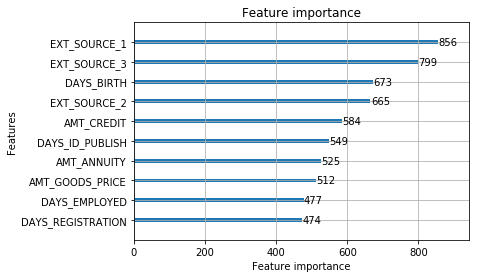

In [11]:
# measure performance
LGBM_bayes_measure = measure_performance(X = X_test, y = y_test, clf = LGBM_bayes, show_classification_report=True, show_confusion_matrix=True, show_roc_auc = True)

# feature importances
print('Feature importances:', list(LGBM_bayes.feature_importances_))

# visualization
print('Plot feature importances...')
ax = lgb.plot_importance(LGBM_bayes_fit, max_num_features=10)
plt.show()

In [12]:
# Submission file
application_test = pd.read_csv('/Users/francislin/Desktop/Machine_Learning_Workshop/Home Credit Default Risk/application_test.csv')
test_df = label_encoder(application_test)[0]

#Bayes Optimization
out_bayes = pd.DataFrame({"SK_ID_CURR":test_df["SK_ID_CURR"], "TARGET":LGBM_bayes.predict_proba(test_df)[:,1]})
out_bayes.to_csv("submissions_HomeCredit_bayes_opt_V1.csv", index=False)
%pwd

'/Users/francislin/JrML/HomeCredit_test'

In [14]:
print("lightGBM_V1:"+"'num_leaves': 44.129734576443774, 'feature_fraction': 0.8387692998325885, 'bagging_fraction': \
0.964379127781789, 'max_depth': 8.696299192514102, 'lambda_l1': 0.5149412705392703, 'lambda_l2': 2.105089121909636, \
'min_split_gain': 0.03571009178546206, 'min_child_weight': 6.888302858167483, \
'max_bin': 49.43907550695737"+"Your submission scored 0.739")

lightGBM_V1:'num_leaves': 44.129734576443774, 'feature_fraction': 0.8387692998325885, 'bagging_fraction': 0.964379127781789, 'max_depth': 8.696299192514102, 'lambda_l1': 0.5149412705392703, 'lambda_l2': 2.105089121909636, 'min_split_gain': 0.03571009178546206, 'min_child_weight': 6.888302858167483, 'max_bin': 49.43907550695737Your submission scored 0.739
